In [1]:
import fastai
from fastai.vision import *
from fastai.vision.models.unet import *
import torch.nn as nn
from fastai.layers import *
import numpy as np
import torch
from torch.distributions import Normal

In [2]:
fastai.__version__

'1.0.49'

In [3]:
def log10(x):
    return torch.log(x)/ torch.log(torch.tensor(10.0))

def PSNR(y_true, y_pred):
    max_pixel = 1
    y_pred = torch.clamp(y_pred, 0.0, 1)
    return 10.0 * float(log10((max_pixel ** 2) / (torch.mean(torch.pow(y_pred - y_true, 2)))))

In [4]:
path = './dataset/'
size = 256
bs = 6

In [5]:
def _noise(image):
    mean = 0
    var = 0.07
    sigma = var**0.5
    n_dist = Normal(mean, var)
    gauss = n_dist.sample((image.shape))
    noisy = image + gauss
    return torch.clamp(noisy, 0.0, 1)
    
noise_ = TfmPixel(_noise)

In [6]:
src = ImageImageList.from_folder(path)
src = src.split_by_folder(train='train', valid='valid')

#tfms = [get_transforms(xtra_tfms=[noise_()])[0][-1]]
tfms = get_transforms(xtra_tfms=[noise_()])

def get_data(bs,size):
    data = (src.label_from_func(lambda x: x)
           .transform((tfms), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
data = get_data(bs, size)

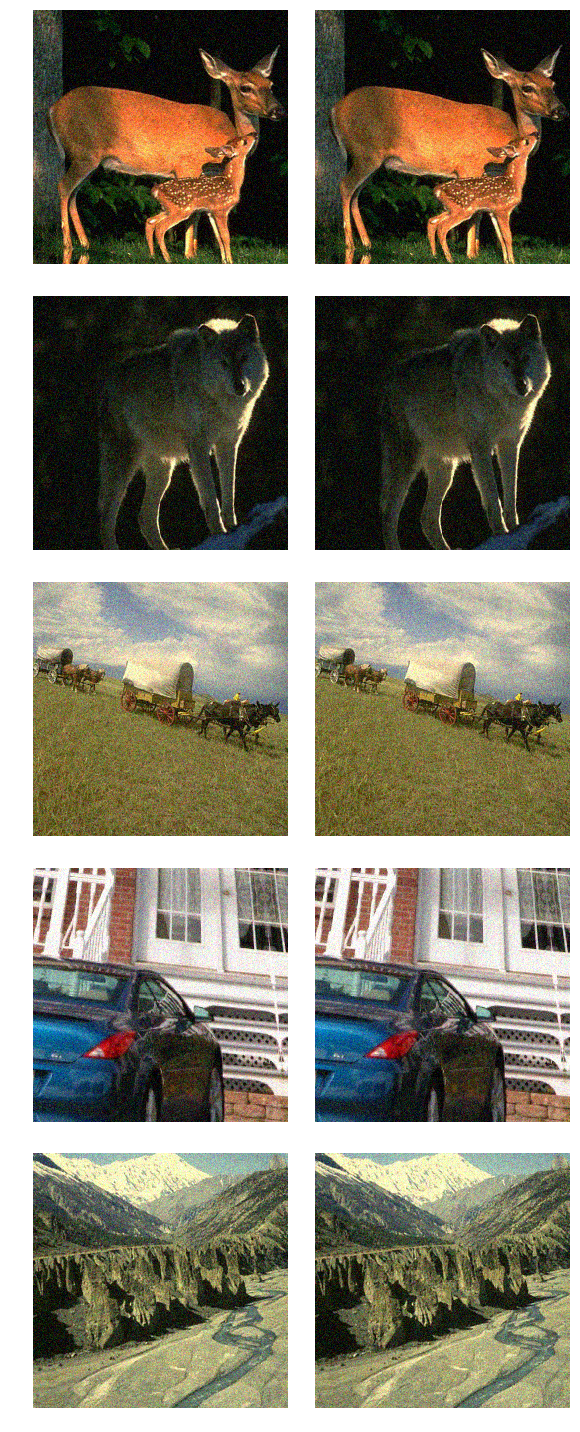

In [8]:
data.show_batch()

In [9]:
l = unet_learner(data, arch=models.resnet18, loss_func=MSELossFlat())

In [10]:
# l.load('saved_')#pred = l.fit_one_cycle(10)

In [11]:
l.fit_one_cycle(50)

epoch,train_loss,valid_loss,time
0,0.451157,0.123659,00:33
1,0.258452,0.047451,00:26
2,0.188946,0.027955,00:26
3,0.153228,0.017738,00:26
4,0.134312,0.012201,00:26
5,0.123514,0.009863,00:26
6,0.117864,0.009536,00:26
7,0.114878,0.012916,00:26
8,0.113707,0.011294,00:26
9,0.114719,0.014832,00:26


In [12]:
l.save("gaussian_noise_256")

In [14]:
l.load('gaussian_noise_256')

Learner(data=ImageDataBunch;

Train: LabelList (227 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset;

Valid: LabelList (64 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
     

In [15]:
import os
import pandas as pd
def psnr_checker(dir_path):
    files = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
    model_psnr = []
    corrupted_psnr = []
    for file in files:
        x,y = image_psnr(file)
        model_psnr.append(x), corrupted_psnr.append(y)
        
    return pd.DataFrame({'File':files, 'M_PSNR':model_psnr, 'C_PSNR':corrupted_psnr})
    

In [16]:
def image_psnr(img_path):
    x = open_image(img_path, after_open= lambda x : x.resize((size,size)))
    noisy = noise_(x.clone())
    out = l.predict(noisy)
    
    return PSNR(x.data, out[0].data), PSNR(x.data, noisy.data)

In [17]:
df = psnr_checker('./dataset/test/')

In [18]:
df['Diff'] = df['M_PSNR'] - df['C_PSNR']

In [19]:
df.sort_values(by='Diff',ascending=False)

,File,M_PSNR,C_PSNR,Diff
14,./dataset/test/3096.jpg,36.913087,23.133223,13.779864
99,./dataset/test/42049.jpg,34.028454,23.144932,10.883522
118,./dataset/test/227092.jpg,33.967927,23.089454,10.878472
183,./dataset/test/143090.jpg,33.324711,23.219194,10.105517
74,./dataset/test/189080.jpg,33.433471,23.389766,10.043705
6,./dataset/test/106024.jpg,33.221612,23.570693,9.650919
53,./dataset/test/14037.jpg,33.243628,23.618333,9.625294
113,./dataset/test/45096.jpg,33.707547,24.191906,9.515641
37,./dataset/test/foreman.bmp,32.847388,23.409092,9.438295
204,./dataset/test/260058.jpg,32.405453,23.142622,9.262831


In [26]:
x = open_image('./dataset/test/baboon.bmp', after_open= lambda x : x.resize((size, size)))
noisy = noise_(x.clone())
out = l.predict(noisy)

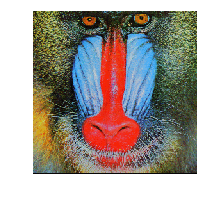

In [27]:
x.show()

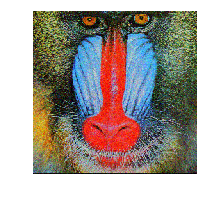

In [28]:
Image(noisy.data).show()

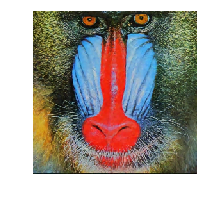

In [29]:
out[0].show()

In [24]:
PSNR(x.data, out[0].data)

26.631720066070557

In [25]:
PSNR(x.data, noisy.data)

23.441457748413086

In [ ]:
x.shape

In [ ]:
out[0].shape